In [ ]:
# --------------------------
# 0. Import Dependencies
# --------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import CIFAR10
from torchvision import transforms

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA    # <-- NEW import for PCA
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

In [ ]:
# --------------------------
# 1. Load CIFAR-10 Dataset
# --------------------------
print("Loading CIFAR-10 dataset...")

transform = transforms.ToTensor()
train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)

class_names = train_data.classes

# Prepare raw pixel data: flatten and normalize
X_train_raw = train_data.data.reshape(-1, 32*32*3).astype(np.float32) / 255.0
y_train = np.array(train_data.targets)
X_test_raw = test_data.data.reshape(-1, 32*32*3).astype(np.float32) / 255.0
y_test = np.array(test_data.targets)

Loading CIFAR-10 dataset...


Visualizing 10 samples per class...


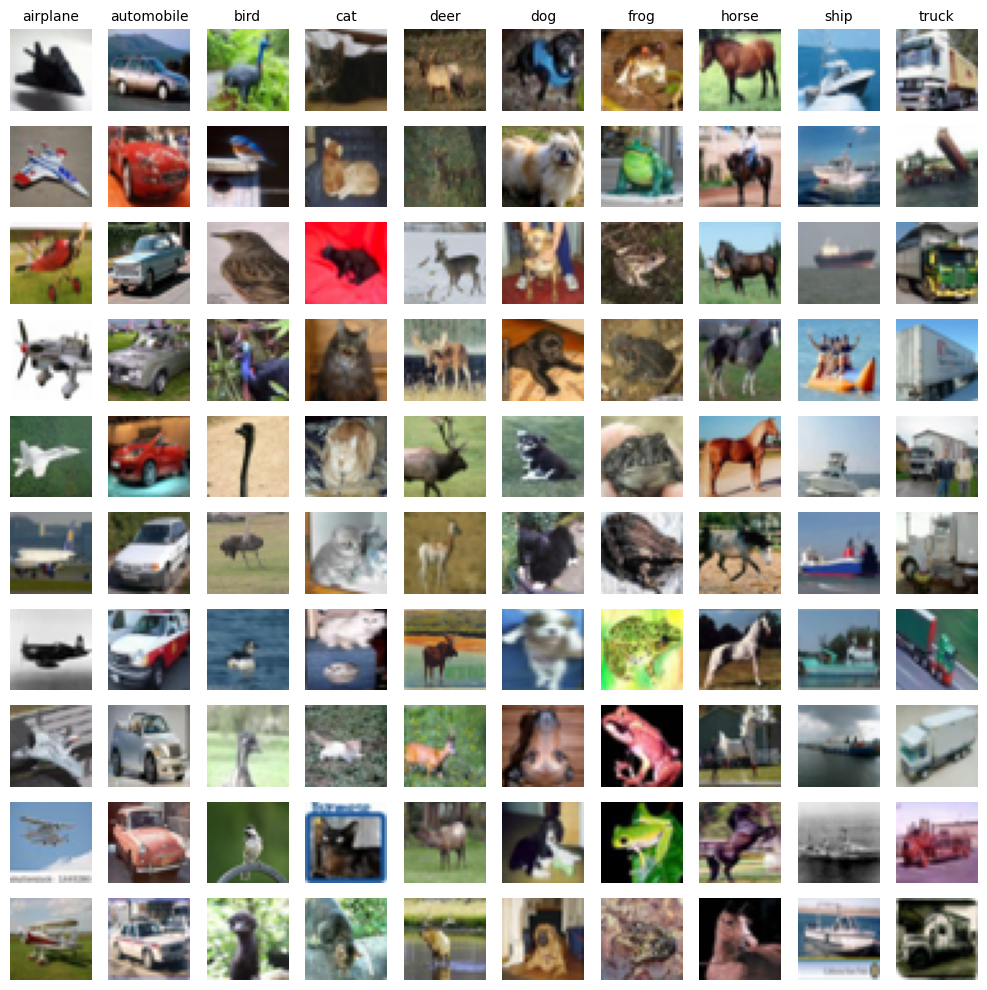

In [ ]:
# --------------------------
# 2. Visualize CIFAR-10 Samples by Class
# --------------------------
print("Visualizing 10 samples per class...")

class_to_images = {i: [] for i in range(10)}
for img, label in train_data:
    if len(class_to_images[label]) < 10:
        class_to_images[label].append(img)
    if all(len(v) == 10 for v in class_to_images.values()):
        break

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for col in range(10):
    images = class_to_images[col]
    for row in range(10):
        img = np.transpose(images[row].numpy(), (1, 2, 0))
        ax = axes[row, col]
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(class_names[col], fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------
# 3. Define MLP Feature Extractor
# --------------------------
print("Defining MLP feature extractor...")

class MLPFeatureExtractor(nn.Module):
    def __init__(self, input_dim=32*32*3, hidden_dim=512, feature_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, feature_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_feat = MLPFeatureExtractor().to(device)

Defining MLP feature extractor...


In [ ]:
# --------------------------
# 4. Train MLP with Classifier Head
# --------------------------
print("Training MLP feature extractor...")

classifier_head = nn.Linear(128, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(mlp_feat.parameters()) + list(classifier_head.parameters()), lr=0.001)
BATCH_SIZE = 512
EPOCHS = 10

train_tensor = torch.tensor(X_train_raw)
train_labels = torch.tensor(y_train)
train_dataset = TensorDataset(train_tensor, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("\nTraining MLP for feature extraction...")
start_mlp = time.time()
mlp_feat.train()
for epoch in range(EPOCHS):
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        feats = mlp_feat(xb)
        logits = classifier_head(feats)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}")
end_mlp = time.time()
print(f"MLP training time: {(end_mlp - start_mlp):.2f} seconds")

Training MLP feature extractor...

Training MLP for feature extraction...
Epoch 1/10 - Loss: 1.9359
Epoch 2/10 - Loss: 1.7349
Epoch 3/10 - Loss: 1.6463
Epoch 4/10 - Loss: 1.5914
Epoch 5/10 - Loss: 1.5336
Epoch 6/10 - Loss: 1.4972
Epoch 7/10 - Loss: 1.4622
Epoch 8/10 - Loss: 1.4340
Epoch 9/10 - Loss: 1.4071
Epoch 10/10 - Loss: 1.3794
MLP training time: 7.41 seconds


In [ ]:
# -----------------------------
# 5. Extract MLP Features
# -----------------------------
print("\nExtracting features using trained MLP...")

mlp_feat.eval()
with torch.no_grad():
    X_train_feats = mlp_feat(torch.tensor(X_train_raw).to(device)).cpu().numpy()
    X_test_feats = mlp_feat(torch.tensor(X_test_raw).to(device)).cpu().numpy()


Extracting features using trained MLP...


In [ ]:
# --------------------------
# 6a. Feature Scaling for MLP features
# --------------------------
print("Scaling MLP features using StandardScaler...")

scaler_feats = StandardScaler()
X_train_feats_scaled = scaler_feats.fit_transform(X_train_feats)
X_test_feats_scaled = scaler_feats.transform(X_test_feats)

# --------------------------
# 6b. PCA Dimensionality Reduction on Raw Pixels
# --------------------------
print("Applying PCA to raw pixels for dimensionality reduction...")
pca = PCA(n_components=100, random_state=69)
X_train_raw_pca = pca.fit_transform(X_train_raw)
X_test_raw_pca = pca.transform(X_test_raw)

Scaling MLP features using StandardScaler...
Applying PCA to raw pixels for dimensionality reduction...


In [ ]:
# --------------------------
# 7. Instantiate Models with Tuned Hyperparameters (no GridSearchCV)
# --------------------------
print("Instantiating classical ML models with fixed hyperparameters...")

knn_best = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='manhattan'
)

svm_best = SVC(
    C=1,
    kernel='linear',
    gamma='scale'
)

dt_best = DecisionTreeClassifier(
    criterion='gini',
    max_depth=20,
    min_samples_split=2,
    random_state=69
)

Instantiating classical ML models with fixed hyperparameters...


In [ ]:
# --------------------------
# 8. Helper Function: train & evaluate models (no GridSearchCV)
# --------------------------
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name, feature_type):
    print(f"\nTraining and evaluating {model_name} with {feature_type} features...")
    start_time = time.time()

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, preds)}")

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix ({feature_type})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    end_time = time.time()
    print(f"Training time for {model_name} ({feature_type}): {(end_time - start_time):.2f} seconds")

    # Save the model
    model_path = f"{model_name.replace(' ', '_')}_{feature_type.replace(' ', '_')}.joblib"
    from joblib import dump
    dump(model, model_path)
    print(f"Saved model to: {model_path}")

    return acc


Training and evaluating KNN with Raw PCA features...
Accuracy: 0.3841
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.49      1000
           1       0.76      0.23      0.35      1000
           2       0.28      0.46      0.35      1000
           3       0.32      0.17      0.23      1000
           4       0.26      0.55      0.36      1000
           5       0.44      0.23      0.30      1000
           6       0.34      0.45      0.39      1000
           7       0.65      0.30      0.41      1000
           8       0.43      0.71      0.53      1000
           9       0.72      0.20      0.32      1000

    accuracy                           0.38     10000
   macro avg       0.47      0.38      0.37     10000
weighted avg       0.47      0.38      0.37     10000



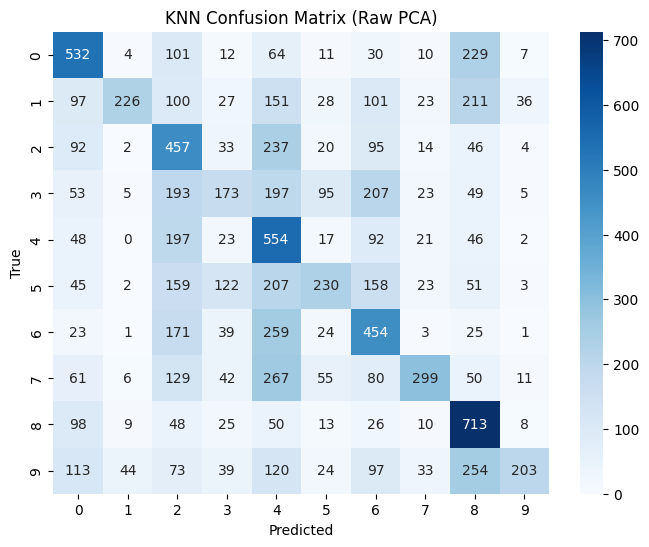

Training time for KNN (Raw PCA): 13.78 seconds
Saved model to: KNN_Raw_PCA.joblib

Training and evaluating SVM with Raw PCA features...
Accuracy: 0.4091
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.49      0.48      1000
           1       0.46      0.50      0.48      1000
           2       0.30      0.29      0.30      1000
           3       0.32      0.32      0.32      1000
           4       0.36      0.28      0.32      1000
           5       0.35      0.33      0.34      1000
           6       0.41      0.50      0.45      1000
           7       0.46      0.41      0.44      1000
           8       0.49      0.51      0.50      1000
           9       0.45      0.46      0.45      1000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.41     10000
weighted avg       0.41      0.41      0.41     10000



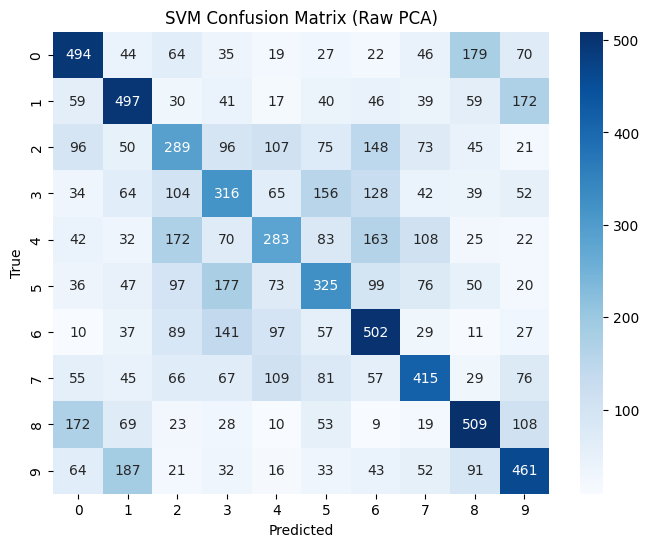

Training time for SVM (Raw PCA): 1365.97 seconds
Saved model to: SVM_Raw_PCA.joblib

Training and evaluating Decision Tree with Raw PCA features...
Accuracy: 0.2756
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.39      0.37      1000
           1       0.34      0.31      0.32      1000
           2       0.21      0.22      0.22      1000
           3       0.18      0.17      0.17      1000
           4       0.24      0.27      0.25      1000
           5       0.24      0.22      0.23      1000
           6       0.27      0.29      0.28      1000
           7       0.24      0.22      0.23      1000
           8       0.39      0.39      0.39      1000
           9       0.30      0.28      0.29      1000

    accuracy                           0.28     10000
   macro avg       0.28      0.28      0.28     10000
weighted avg       0.28      0.28      0.28     10000



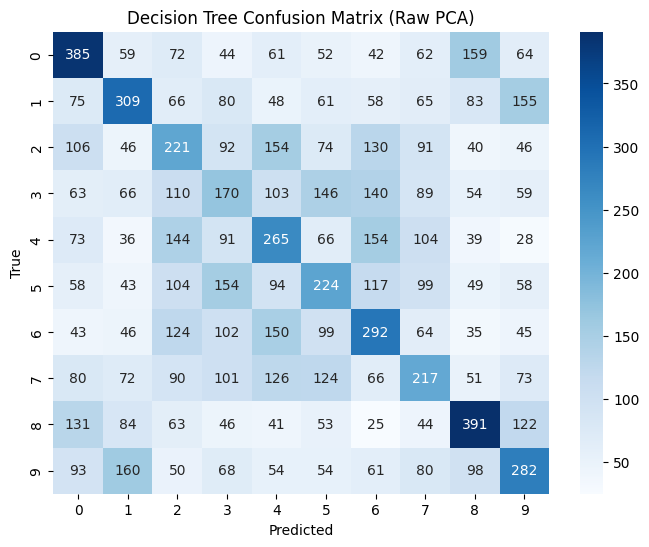

Training time for Decision Tree (Raw PCA): 12.82 seconds
Saved model to: Decision_Tree_Raw_PCA.joblib

Training and evaluating KNN with MLP Features features...
Accuracy: 0.4789
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1000
           1       0.63      0.58      0.60      1000
           2       0.36      0.38      0.37      1000
           3       0.31      0.28      0.29      1000
           4       0.41      0.41      0.41      1000
           5       0.40      0.35      0.37      1000
           6       0.45      0.56      0.50      1000
           7       0.55      0.54      0.54      1000
           8       0.58      0.64      0.61      1000
           9       0.55      0.52      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



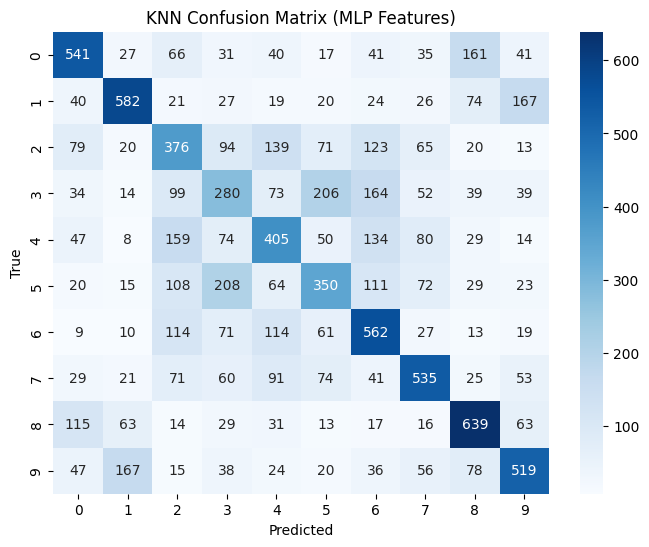

Training time for KNN (MLP Features): 17.42 seconds
Saved model to: KNN_MLP_Features.joblib

Training and evaluating SVM with MLP Features features...
Accuracy: 0.5140
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.56      0.57      1000
           1       0.62      0.64      0.63      1000
           2       0.39      0.37      0.38      1000
           3       0.35      0.34      0.35      1000
           4       0.45      0.43      0.44      1000
           5       0.43      0.38      0.40      1000
           6       0.51      0.61      0.56      1000
           7       0.58      0.56      0.57      1000
           8       0.62      0.67      0.65      1000
           9       0.58      0.58      0.58      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



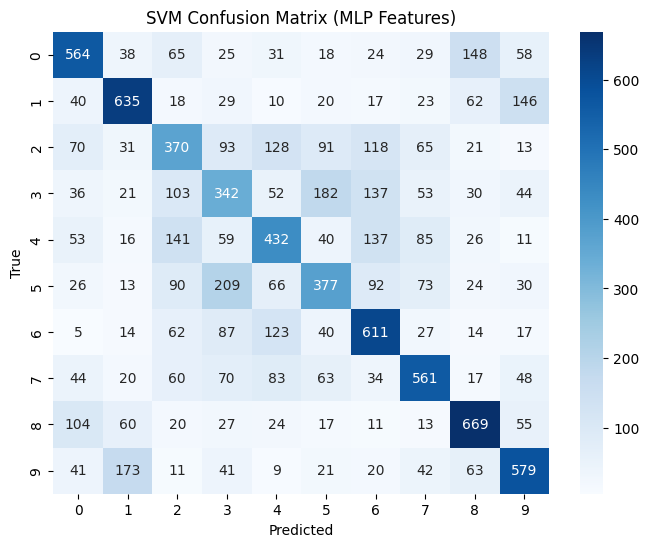

Training time for SVM (MLP Features): 392.12 seconds
Saved model to: SVM_MLP_Features.joblib

Training and evaluating Decision Tree with MLP Features features...
Accuracy: 0.3814
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.44      0.44      1000
           1       0.48      0.46      0.47      1000
           2       0.25      0.27      0.26      1000
           3       0.27      0.27      0.27      1000
           4       0.32      0.32      0.32      1000
           5       0.28      0.27      0.28      1000
           6       0.40      0.40      0.40      1000
           7       0.42      0.42      0.42      1000
           8       0.53      0.53      0.53      1000
           9       0.44      0.43      0.43      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.38     10000
weighted avg       0.38      0.38      0.38     10000



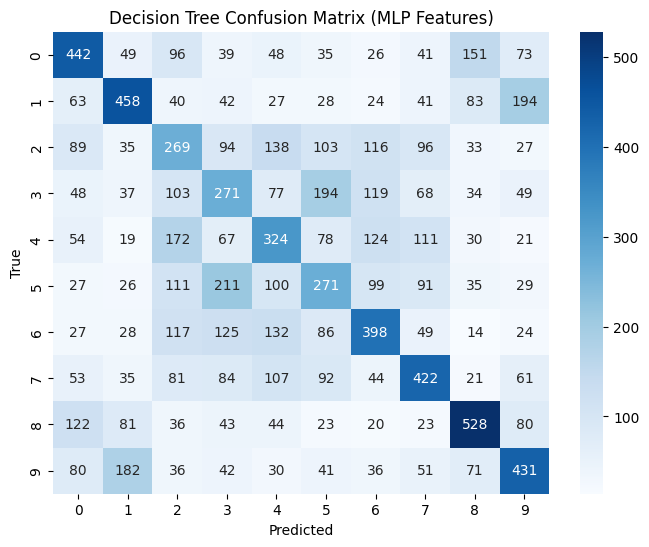

Training time for Decision Tree (MLP Features): 6.68 seconds
Saved model to: Decision_Tree_MLP_Features.joblib

Total time for full pipeline: 1808.94 seconds


In [ ]:
# --------------------------
# 9. Run Experiments
# --------------------------
overall_start = time.time()
results = {}

# -- On PCA Reduced Raw Pixels
results['KNN Raw PCA'] = train_and_evaluate(knn_best, X_train_raw_pca, y_train, X_test_raw_pca, y_test, 'KNN', 'Raw PCA')
results['SVM Raw PCA'] = train_and_evaluate(svm_best, X_train_raw_pca, y_train, X_test_raw_pca, y_test, 'SVM', 'Raw PCA')
results['DT Raw PCA'] = train_and_evaluate(dt_best, X_train_raw_pca, y_train, X_test_raw_pca, y_test, 'Decision Tree', 'Raw PCA')

# -- On MLP Features
results['KNN MLP'] = train_and_evaluate(knn_best, X_train_feats_scaled, y_train, X_test_feats_scaled, y_test, 'KNN', 'MLP Features')
results['SVM MLP'] = train_and_evaluate(svm_best, X_train_feats_scaled, y_train, X_test_feats_scaled, y_test, 'SVM', 'MLP Features')
results['DT MLP'] = train_and_evaluate(dt_best, X_train_feats_scaled, y_train, X_test_feats_scaled, y_test, 'Decision Tree', 'MLP Features')

overall_end = time.time()
print(f"\nTotal time for full pipeline: {(overall_end - overall_start):.2f} seconds")

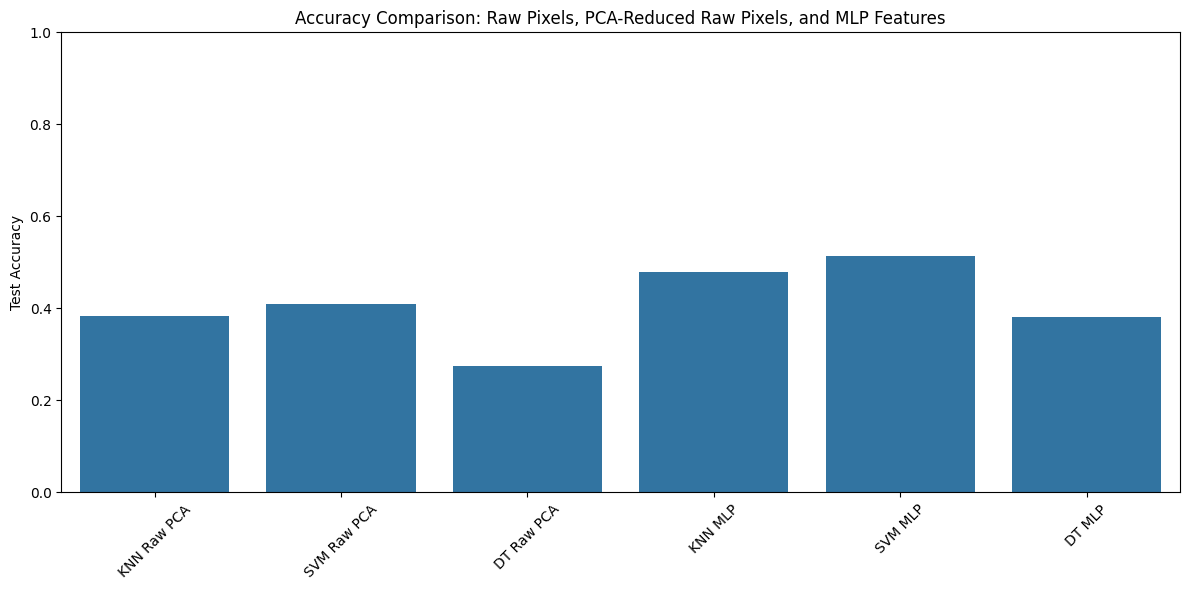

In [ ]:
# --------------------------
# 10. Plot Accuracy Comparison
# --------------------------
plt.figure(figsize=(12, 6))
names = list(results.keys())
values = list(results.values())
sns.barplot(x=names, y=values)
plt.title("Accuracy Comparison: Raw Pixels, PCA-Reduced Raw Pixels, and MLP Features")
plt.ylabel("Test Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()